# Implementing a Recommender System with SageMaker, MXNet, and Gluon
_**Making Video Recommendations Using Neural Networks and Embeddings**_

--- 

---

*This work is based on content from the [Cyrus Vahid's 2017 re:Invent Talk](https://github.com/cyrusmvahid/gluontutorials/blob/master/recommendations/MLPMF.ipynb)*


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Explore](#Explore)
  1. [Clean](#Clean)
  1. [Prepare](#Prepare)
1. [Train Locally](#Train-Locally)
  1. [Define Network](#Define-Network)
  1. [Set Parameters](#Set-Parameters)
  1. [Execute](#Execute)
1. [Train with SageMaker](#Train-with-SageMaker)
  1. [Wrap Code](#Wrap-Code)
  1. [Move Data](#Move-Data)
  1. [Submit](#Submit)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Wrap-up](#Wrap-up)

---

## Background

AWS Seoul Summit 2020의 '아직도 파이썬으로 머신러닝하니? 난 SQL로 바로 쓴다' 세션 데모를 위한 SageMaker 추천 모델 학습 과정을 보여주기 위한 노트북입니다. Kaggle의 [eCommerce behavior data from multi category store](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) 데이터를 학습하여 User에게 Product를 제공하는 모델을 만들고 추론 endpoint를 구성합니다. 이 노트북은 SageMaker Example Notebooks으로 제공되는 [Gluon Recommender System](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/gluon_recommender_system/gluon_recommender_system.ipynb) 을 참고하여 작성되었습니다. 모델 훈련/평가/추론에 동일한 방식을 적용하였으니 착오 없으시길 바랍니다.

---

## Setup

_This notebook was created and tested on an ml.p3.2xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `get_execution_role()` call with the appropriate full IAM role arn string(s).

In [1]:
bucket = 'summit-2020-db-ml'
prefix = 'sagemaker/DEMO-gluon-recsys'

import sagemaker
role = sagemaker.get_execution_role()

Now let's load the Python libraries we'll need for the remainder of this example notebook.

In [2]:
import os
import mxnet as mx
from mxnet import gluon, nd, ndarray
from mxnet.metric import MSE
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.mxnet import MXNet
import boto3
import json
import matplotlib.pyplot as plt

---

## Data

### Explore

S3에서 실습 데이터를 로컬 스토리지로 가져옵니다.

In [3]:
!mkdir /tmp/recsys/
!aws s3 cp s3://summit-2020-db-ml/ecommerce-behavior-data/org/2019-Oct.csv /tmp/recsys/
!aws s3 cp s3://summit-2020-db-ml/ecommerce-behavior-data/org/2019-Nov.csv /tmp/recsys/

mkdir: cannot create directory ‘/tmp/recsys/’: File exists
download: s3://summit-2020-db-ml/ecommerce-behavior-data/org/2019-Oct.csv to ../../../../tmp/recsys/2019-Oct.csv
download: s3://summit-2020-db-ml/ecommerce-behavior-data/org/2019-Nov.csv to ../../../../tmp/recsys/2019-Nov.csv


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [4]:
df_Oct = pd.read_csv('/tmp/recsys/2019-Oct.csv', delimiter=',',error_bad_lines=False)
df_Nov = pd.read_csv('/tmp/recsys/2019-Nov.csv', delimiter=',',error_bad_lines=False)
df = pd.concat([df_Oct,df_Nov], ignore_index=True)
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


We can see this dataset includes information like:

- `event_time`: When event is was happened (UTC)
- `event_type`: Event type: one of [view, cart, remove_from_cart, purchase]
- `product_id`: Product ID
- `category_id`: Product category ID
- `category_code`: Category meaningful name (if present)
- `brand`: Brand name in lower case (if present)
- `price`: Product price
- `user_id`: Permanent user ID
- `user_session`: User session ID

이 예제에서는 `user_id`, `product_id`, `event_type`만 학습에 사용합니다. `category_id`, `category_code`, `brand`는 추후 결과 데이터를 확인하기 위해 사용합니다. `event_type`의 값 'view, cart, remove_from_cart, purchase'를 각각 0,1,2,3으로 수치화하여 `event_type_digit`를 생성합니다.

In [5]:
df = df[['user_id', 'product_id', 'event_type', 'category_id', 'category_code', 'brand']]
df['event_type_digit'] = df['event_type'].apply(lambda x: 4 if x=='purchase' else 3 if x=='cart' else 2 if x=='remove_from_cart' else 1)

Because most people haven't viewed most products, and people purchase fewer products than we actually view, we'd expect our data to be sparse.  Our algorithm should work well with this sparse problem in general, but we may still want to clean out some of the long tail.  Let's look at some basic percentiles to confirm.

In [6]:
users = df['user_id'].value_counts()
products = df['product_id'].value_counts()

quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
print('users\n', users.quantile(quantiles))
print('products\n', products.quantile(quantiles))

users
 0.00        1.0
0.01        1.0
0.02        1.0
0.03        1.0
0.04        1.0
0.05        1.0
0.10        1.0
0.25        2.0
0.50        5.0
0.75       18.0
0.90       51.0
0.95       88.0
0.96      103.0
0.97      124.0
0.98      157.0
0.99      225.0
1.00    22929.0
Name: user_id, dtype: float64
products
 0.00          1.0
0.01          1.0
0.02          1.0
0.03          1.0
0.04          1.0
0.05          2.0
0.10          3.0
0.25         12.0
0.50         51.0
0.75        196.0
0.90        686.0
0.95       1528.0
0.96       1927.0
0.97       2580.0
0.98       3816.0
0.99       7091.0
1.00    1136760.0
Name: product_id, dtype: float64


### Clean

Let's filter out this long tail.

In [7]:
users = users[users >= 5]
products = products[products >= 10]

reduced_df = df.merge(pd.DataFrame({'user_id': users.index})).merge(pd.DataFrame({'product_id': products.index}))

Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [8]:
users = reduced_df['user_id'].value_counts()
products = reduced_df['product_id'].value_counts()

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [9]:
user_index = pd.DataFrame({'user_id': users.index, 'user': np.arange(users.shape[0])})
product_index = pd.DataFrame({'product_id': products.index, 
                              'item': np.arange(products.shape[0])})

reduced_df = reduced_df.merge(user_index).merge(product_index)
reduced_df.head()

,user_id,product_id,event_type,category_id,category_code,brand,event_type_digit,user,item
0,541312140,44600062,view,2103807459595387724,NaN,shiseido,1,94047,35728
1,541312140,44600062,view,2103807459595387724,NaN,shiseido,1,94047,35728
2,512840413,44600062,view,2103807459595387724,NaN,shiseido,1,12025,35728
3,528001475,44600062,view,2103807459595387724,NaN,shiseido,1,364,35728
4,528001475,44600062,view,2103807459595387724,NaN,shiseido,1,364,35728


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [10]:
test_df = reduced_df.groupby('user_id').last().reset_index()

train_df = reduced_df.merge(test_df[['user_id', 'product_id']], 
                            on=['user_id', 'product_id'], 
                            how='outer', 
                            indicator=True)
train_df = train_df[(train_df['_merge'] == 'left_only')]

Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [11]:
batch_size = 1024

train = gluon.data.ArrayDataset(nd.array(train_df['user'].values, dtype=np.float32),
                                nd.array(train_df['item'].values, dtype=np.float32),
                                nd.array(train_df['event_type_digit'].values, dtype=np.float32))
test  = gluon.data.ArrayDataset(nd.array(test_df['user'].values, dtype=np.float32),
                                nd.array(test_df['item'].values, dtype=np.float32),
                                nd.array(test_df['event_type_digit'].values, dtype=np.float32))

train_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')
test_iter = gluon.data.DataLoader(train, shuffle=True, num_workers=4, batch_size=batch_size, last_batch='rollover')

---

## Train Locally

### Define Network

Let's start by defining the neural network version of our matrix factorization task.  In this case, our network is quite simple.  The main components are:
- [Embeddings](https://mxnet.incubator.apache.org/api/python/gluon/nn.html#mxnet.gluon.nn.Embedding) which turn our indexes into dense vectors of fixed size.  In this case, 64.
- [Dense layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dense) with ReLU activation.  Each dense layer has the same number of units as our number of embeddings.  Our ReLU activation here also adds some non-linearity to our matrix factorization.
- [Dropout layers](https://mxnet.incubator.apache.org/api/python/gluon.html#mxnet.gluon.nn.Dropout) which can be used to prevent over-fitting.
- Matrix multiplication of our user matrix and our item matrix to create an estimate of our rating matrix.

In [12]:
class MFBlock(gluon.HybridBlock):
    def __init__(self, max_users, max_items, num_emb, dropout_p=0.5):
        super(MFBlock, self).__init__()
        
        self.max_users = max_users
        self.max_items = max_items
        self.dropout_p = dropout_p
        self.num_emb = num_emb
        
        with self.name_scope():
            self.user_embeddings = gluon.nn.Embedding(max_users, num_emb)
            self.item_embeddings = gluon.nn.Embedding(max_items, num_emb)
            
            self.dropout_user = gluon.nn.Dropout(dropout_p)
            self.dropout_item = gluon.nn.Dropout(dropout_p)

            self.dense_user   = gluon.nn.Dense(num_emb, activation='relu')
            self.dense_item = gluon.nn.Dense(num_emb, activation='relu')
            
    def hybrid_forward(self, F, users, items):
        a = self.user_embeddings(users)
        a = self.dense_user(a)
        
        b = self.item_embeddings(items)
        b = self.dense_item(b)

        predictions = self.dropout_user(a) * self.dropout_item(b)     
        predictions = F.sum(predictions, axis=1)
        return predictions

In [13]:
num_embeddings = 64

net = MFBlock(max_users=user_index.shape[0], 
              max_items=product_index.shape[0],
              num_emb=num_embeddings,
              dropout_p=0.5)


### Set Parameters

Let's initialize network weights and set our optimization parameters.

In [14]:
# Initialize network parameters
ctx = mx.gpu()
net.collect_params().initialize(mx.init.Xavier(magnitude=60),
                                ctx=ctx,
                                force_reinit=True)
net.hybridize()

# Set optimization parameters
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

trainer = gluon.Trainer(net.collect_params(),
                        opt,
                        {'learning_rate': lr,
                         'wd': wd,
                         'momentum': momentum})

### Execute

Let's define a function to carry out the training of our neural network.

In [15]:
def execute(train_iter, test_iter, net, epochs, ctx):
    
    loss_function = gluon.loss.L2Loss()
    for e in range(epochs):
        
        print("epoch: {}".format(e))
        
        for i, (user, item, label) in enumerate(train_iter):
                user = user.as_in_context(ctx)
                item = item.as_in_context(ctx)
                label = label.as_in_context(ctx)
                
                with mx.autograd.record():
                    output = net(user, item)               
                    loss = loss_function(output, label)
                    
                loss.backward()
                trainer.step(batch_size)

        print("EPOCH {}: MSE ON TRAINING and TEST: {}. {}".format(e,
                                                                   eval_net(train_iter, net, ctx, loss_function),
                                                                   eval_net(test_iter, net, ctx, loss_function)))
    print("end of training")
    return net

Let's also define a function which evaluates our network on a given dataset.  This is called by our `execute` function above to provide mean squared error values on our training and test datasets.

In [16]:
def eval_net(data, net, ctx, loss_function):
    acc = MSE()
    for i, (user, item, label) in enumerate(data):
        
            user = user.as_in_context(ctx)
            item = item.as_in_context(ctx)
            label = label.as_in_context(ctx)
            predictions = net(user, item).reshape((batch_size, 1))
            acc.update(preds=[predictions], labels=[label])
   
    return acc.get()[1]

Now, let's train for a few epochs.

In [ ]:
%%time

epochs = 3

trained_net = execute(train_iter, test_iter, net, epochs, ctx)

epoch: 0


#### Early Validation

We can see our training error going down, but our validation accuracy bounces around a bit.  Let's check how our model is predicting for an individual user.  We could pick randomly, but for this case, let's try user #6.

In [ ]:
product_index['u6_predictions'] = trained_net(nd.array([6] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u6_predictions', ascending=False)

Now let's compare this to the predictions for another user (we'll try user #7).

In [ ]:
product_index['u7_predictions'] = trained_net(nd.array([7] * product_index.shape[0]).as_in_context(ctx), 
                                              nd.array(product_index['item'].values).as_in_context(ctx)).asnumpy()
product_index.sort_values('u7_predictions', ascending=False)

The predicted ratings are different between the two users, but the same top (and bottom) items for user #6 appear for #7 as well.  Let's look at the correlation across the full set of 38K items to see if this relationship holds.

In [ ]:
product_index[['u6_predictions', 'u7_predictions']].plot.scatter('u6_predictions', 'u7_predictions')
plt.show()

We can see that this correlation is nearly perfect.  Essentially the average rating of items dominates across users and we'll recommend the same well-reviewed items to everyone.  As it turns out, we can add more embeddings and this relationship will go away since we're better able to capture differential preferences across users.

If we ran this outside of our Notebook Instance we could run larger jobs and move on to other work would improve productivity.

---

## Train with SageMaker

Now that we've trained on this smaller dataset, we can expand training in SageMaker's distributed, managed training environment.

### Wrap Code

To use SageMaker's pre-built MXNet container, we'll need to wrap our code from above into a Python script.  There's a great deal of flexibility in using SageMaker's pre-built containers, and detailed documentation can be found [here](https://github.com/aws/sagemaker-python-sdk#mxnet-sagemaker-estimators), but for our example, it consisted of:
1. Wrapping all data preparation into a `prepare_train_data` function (we could name this whatever we like)
1. Copying and pasting classes and functions from above word-for-word
1. Defining a `train` function that:
  1. Adds a bit of new code to pick up the input TSV dataset on the SageMaker Training cluster
  1. Takes in a dict of hyperparameters (which we specified as globals above)
  1. Creates the net and executes training

In [ ]:
!cat recommender.py

### Test Locally

Now we can test our train function locally.  This helps ensure we don't have any bugs before submitting our code to SageMaker's pre-built MXNet container.

In [ ]:
%%time

import recommender

local_test_net, local_customer_index, local_product_index = recommender.train(
    {'train': '/tmp/recsys/'}, 
    {'num_embeddings': 64, 
     'opt': 'sgd', 
     'lr': 0.02, 
     'momentum': 0.9, 
     'wd': 0.,
     'epochs': 3},
    ['local'],
    1)

### Move Data

Holding our data in memory works fine when we're interactively exploring a sample of data, but for larger, longer running processes, we'd prefer to run them in the background with SageMaker Training.  To do this, let's move the dataset to S3 so that it can be picked up by SageMaker training.  This is perfect for use cases like periodic re-training, expanding to a larger dataset, or moving production workloads to larger hardware.

앞에서 다운로드한 두 데이터 파일을 합쳐서 train용 버킷에 업로드 합니다.

In [ ]:
!cat /tmp/recsys/2019-Oct.csv > /tmp/recsys/2019-Oct-Nov.csv
!tail -n +2 /tmp/recsys/2019-Nov.csv >> /tmp/recsys/2019-Oct-Nov.csv

In [ ]:
boto3.client('s3').upload_file('/tmp/recsys/2019-Oct-Nov.csv', bucket, prefix + '/train/2019-Oct-Nov.csv')

### Submit

Now, we can create an MXNet estimator from the SageMaker Python SDK.  To do so, we need to pass in:
1. Instance type and count for our SageMaker Training cluster.  SageMaker's MXNet containers support distributed GPU training, so we could easily set this to multiple ml.p2 or ml.p3 instances if we wanted.
  - *Note, this would require some changes to our recommender.py script as we would need to setup the context an key value store properly, as well as determining if and how to distribute the training data.*
1. An S3 path for out model artifacts and a role with access to S3 input and output paths.
1. Hyperparameters for our neural network.  Since with a 64 dimensional embedding, our recommendations reverted too closely to the mean, let's increase this by an order of magnitude when we train outside of our local instance.  We'll also increase the epochs to see how our accuracy evolves over time. We'll leave all other hyperparameters the same.

Once we use `.fit()` this creates a SageMaker Training Job that spins up instances, loads the appropriate packages and data, runs our `train` function from `recommender.py`, wraps up and saves model artifacts to S3, and finishes by tearing down the cluster.

In [ ]:
opt = 'sgd'
lr = 0.02
momentum = 0.9
wd = 0.

m = MXNet('recommender.py', 
          py_version='py3',
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.p3.2xlarge",
          output_path='s3://{}/{}/output'.format('summit-2020-db-ml', 'ecommerce-behavior-data'),
          hyperparameters={'num_embeddings': 64, 
                           'opt': opt, 
                           'lr': lr, 
                           'momentum': momentum, 
                           'wd': wd,
                           'epochs': 3},
         framework_version='1.1')

m.fit({'train': 's3://{}/{}/train/'.format('summit-2020-db-ml', 'ecommerce-behavior-data')})

2020-04-03 00:22:35 Starting - Starting the training job...
2020-04-03 00:23:05 Starting - Launching requested ML instances......
2020-04-03 00:24:04 Starting - Preparing the instances for training.........
2020-04-03 00:25:11 Downloading - Downloading input data.....................
2020-04-03 00:28:56 Training - Downloading the training image..2020-04-03 00:29:11,829 INFO - root - running container entrypoint
2020-04-03 00:29:11,829 INFO - root - starting train task
2020-04-03 00:29:11,849 INFO - container_support.training - Training starting
2020-04-03 00:29:12,931 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'sagemaker_region': 'ap-northeast-2', 'resource_config': {'current_host': 'algo-1', 'network_interface_name': 'eth0', 'hosts': ['algo-1']}, 'user_script_name': 'recommender.py', 'code_dir': '/opt/ml/code', 'base_dir': '/opt/ml', 'hyperparameters': {'num_embeddings': 64, 'sagemaker_region': 'ap-northeast-2', 'sagemaker_enable_cloudwatch_metrics': False, 'sagemaker_p

---

## Host

Now that we've trained our model, deploying it to a real-time, production endpoint is easy.

In [ ]:
predictor = m.deploy(initial_instance_count=1, 
                     instance_type='ml.m4.xlarge')
predictor.serializer = None

Now that we have an endpoint, let's test it out.  We'll predict user #6's ratings for the top and bottom ASINs from our local model.

*This could be done by sending HTTP POST requests from a separate web service, but to keep things easy, we'll just use the `.predict()` method from the SageMaker Python SDK.*

In [1]:
# 여기도 다른 값으로 채워야함

predictor.predict(json.dumps({'user_id': user_index[user_index['user'] == 6]['user_id'].values.tolist(), 
                              'product_id': ['44600062', '1307067']}))

NameError: name 'predictor' is not defined

*Note, some of our predictions are actually greater than 5, which is to be expected as we didn't do anything special to account for ratings being capped at that value.  Since we are only looking to ranking by predicted rating, this won't create problems for our specific use case.*

### Evaluate

Let's start by calculating a naive baseline to approximate how well our model is doing.  The simplest estimate would be to assume every user item rating is just the average rating over all ratings.

*Note, we could do better by using each individual video's average, however, in this case it doesn't really matter as the same conclusions would hold.*

In [45]:
print('Naive MSE:', np.mean((test_df['event_type_digit'] - np.mean(train_df['event_type_digit'])) ** 2))

Naive MSE: 0.16830452810737762


Now, we'll calculate predictions for our test dataset.

*Note, this will align closely to our CloudWatch output above, but may differ slightly due to skipping partial mini-batches in our eval_net function.*

In [46]:
test_preds = []
for array in np.array_split(test_df[['user_id', 'product_id']].values, 40):
    test_preds += predictor.predict(json.dumps({'user_id': array[:, 0].tolist(), 
                                                'product_id': array[:, 1].tolist()}))

test_preds = np.array(test_preds)
print('MSE:', np.mean((test_df['event_type_digit'] - test_preds) ** 2))

MSE: 0.1660810266571631


We can see that our neural network and embedding model produces substantially better results (~1.27 vs 1.65 on mean square error).

For recommender systems, subjective accuracy also matters.  Let's get some recommendations for a random user to see if they make intuitive sense.

In [47]:
reduced_df[reduced_df['user'] == 6].sort_values(['event_type_digit', 'item'], ascending=[False, True])

,user_id,product_id,event_type,category_id,category_code,brand,event_type_digit,user,item
42632864,512505687,1004836,purchase,2053013555631882655,electronics.smartphone,samsung,4,6,13
29575350,512505687,1004785,purchase,2053013555631882655,electronics.smartphone,huawei,4,6,15
2118153,512505687,1005098,purchase,2053013555631882655,electronics.smartphone,samsung,4,6,46
53695140,512505687,3601250,purchase,2053013563810775923,appliances.kitchen.washer,samsung,4,6,276
15398777,512505687,1004767,cart,2053013555631882655,electronics.smartphone,samsung,3,6,2
15398779,512505687,1004767,cart,2053013555631882655,electronics.smartphone,samsung,3,6,2
15398780,512505687,1004767,cart,2053013555631882655,electronics.smartphone,samsung,3,6,2
15398784,512505687,1004767,cart,2053013555631882655,electronics.smartphone,samsung,3,6,2
12589292,512505687,1004870,cart,2053013555631882655,electronics.smartphone,samsung,3,6,4
29575349,512505687,1004785,cart,2053013555631882655,electronics.smartphone,huawei,3,6,15


As we can see, user #6 seems to like sprawling dramamtic television series and sci-fi, but they dislike silly comedies.

Now we'll loop through and predict user #6's ratings for every common video in the catalog, to see which ones we'd recommend and which ones we wouldn't.

In [48]:
predictions = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions += predictor.predict(json.dumps({'user_id': user_index[user_index['user'] == 6]['user_id'].values.tolist() * array.shape[0], 
                                                 'product_id': array.tolist()}))

predictions = pd.DataFrame({'product_id': product_index['product_id'],
                            'prediction': predictions})

In [51]:
titles = reduced_df.groupby('product_id')['brand'].last().reset_index()
predictions_titles = predictions.merge(titles)
predictions_titles.sort_values(['prediction', 'product_id'], ascending=[False, True])

,product_id,prediction,brand
3,4804056,1.080188,apple
46903,21408638,1.075216,NaN
363,10701101,1.059308,ea
64594,100005226,1.039486,bartek
978,12710969,1.034556,triangle
5274,12711988,1.033455,triangle
14250,12705328,1.027893,matador
10,5100816,1.025105,xiaomi
0,1004856,1.023495,samsung
11154,15300135,1.022837,kingston


Indeed, our predicted highly rated shows have some well-reviewed TV dramas and some sci-fi.  Meanwhile, our bottom rated shows include goofball comedies.

*Note, because of random initialization in the weights, results on subsequent runs may differ slightly.*

Let's confirm that we no longer have almost perfect correlation in recommendations with user #7.

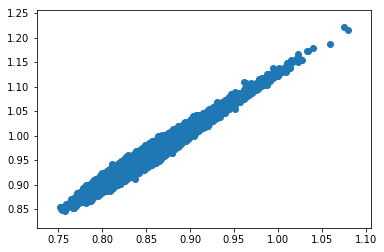

In [52]:
predictions_user7 = []
for array in np.array_split(product_index['product_id'].values, 40):
    predictions_user7 += predictor.predict(json.dumps({'user_id': user_index[user_index['user'] == 7]['user_id'].values.tolist() * array.shape[0], 
                                                       'product_id': array.tolist()}))
plt.scatter(predictions['prediction'], np.array(predictions_user7))
plt.show()

---

## Wrap-up

In this example, we developed a deep learning model to predict customer ratings.  This could serve as the foundation of a recommender system in a variety of use cases.  However, there are many ways in which it could be improved.  For example we did very little with:
- hyperparameter tuning
- controlling for overfitting (early stopping, dropout, etc.)
- testing whether binarizing our target variable would improve results
- including other information sources (video genres, historical ratings, time of review)
- adjusting our threshold for user and item inclusion 

In addition to improving the model, we could improve the engineering by:
- Setting the context and key value store up for distributed training
- Fine tuning our data ingestion (e.g. num_workers on our data iterators) to ensure we're fully utilizing our GPU
- Thinking about how pre-processing would need to change as datasets scale beyond a single machine

Beyond that, recommenders are a very active area of research and techniques from active learning, reinforcement learning, segmentation, ensembling, and more should be investigated to deliver well-rounded recommendations.

### Clean-up (optional)

Let's finish by deleting our endpoint to avoid stray hosting charges.

In [ ]:
sagemaker.Session().delete_endpoint(predictor.endpoint)